## Day 4: Neurons and Networks

Welcome to Day 4! Today, we learn about realistic modelling of synaptic interactions for networks of Hogkin Huxley Neurons and how to implement synapses in TensorFlow.

### How do we model Synapses?

A synapse is defined between two neurons. There can be multiple synapses between two neurons (even of the same type) but here we will consider only single synapses between two neuron. So, there can be atmost $n^2$ synapses of the same type between $n$ different neurons. Each synapse will have their own state variables the dynamics of which can be defined using differential equations. 

For most networks, not all neurons will be connected by all types of synapses. The network of neurons have a certain connectivity that can be represented as an adjacency matrix in the language of graphs. Each type of synapse will have its own connectivity/adjacency matrix.

#### Types of Synapses

There are two major categories of synapses: Exitatory and Inhibitory Synapses.

Here we will focus on implementing one of each category of synapses, Excitatory and Inhibitory. 

#### Modelling Synapses

The current that passes through a synaptic channel depends on the difference between its reversal potential ($E_{syn}$) and the actual value of the membrane potential ($u$), and is $I_{syn}(t)=g_{syn}(t)(u(t)−E_{syn})$. We can describe the synaptic conductance $g_{syn}(t)=g_{max}[O](t)$, by its maximal conductance $g_{max}$ and a gating variable $[O]$, where $[O](𝑡)$ is the fraction of open synaptic channels. Channels open when a neurotransmitter binds to the synapse which is a function of the presynaptic activation $[T]$.

$\frac{d[O]}{dt}=\alpha[T](1−[O])−\beta[O]$

where $\alpha$ is the binding constant, $\beta$ the unbinding constant and $(1−[O])$ the fraction of closed channels where binding of neurotransmitter can occur. The functional form of T depends on the type and nature of the synapse.
	

##### Acetylcholine Synapses (Excitatory)

$$[T]_{ach} = A\ \Theta(t_{max}+t_{fire}+t_{delay}-t)\ \Theta(t-t_{fire}-t_{delay})$$

##### GABAa Synapses (Inhibitory)

$$[T]_{gaba} = \frac{1}{1+e^{-\frac{V(t)-V_0}{\sigma}}}$$

#### Iterating over conditionals in TensorFlow

How would you solve a problem where you have to choose between two options based on the condition provided in a list/array using TensorFlow. Say, you have a array of 10 random variables (say x) between 0 and 1, and you want the output of your code to be 10, if the random variable is greater than 0.5, but -10 when it is not. To perform choices based on the conditions given in a boolean list/array, we can use the TensorFlow function tf.where(). tf.where(cond,a,b) chooses elements from a/b based on conditional array/list cond. Essentially it performs masking between a and b.|

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# create the Tensor with the random variables
x = tf.constant(np.random.uniform(size = (10,)),dtype=tf.float64)

# a list of 10s to select from if true
if_true = tf.constant(10*np.ones((10,)),dtype=tf.float64)

# a list of -10s to select from if false
if_false = tf.constant(-10*np.ones((10,)),dtype=tf.float64)

# perform the conditional masking
selection = tf.where(tf.greater(x,0.5),if_true,if_false)

with tf.Session() as sess:
    x_out = sess.run(x)
    selection_out = sess.run(selection)

print(x_out)
print(selection_out)

[0.37032843 0.87538499 0.53910048 0.56427438 0.55403666 0.28843343
 0.58338231 0.69341365 0.45296054 0.5368501 ]
[-10.  10.  10.  10.  10. -10.  10.  10. -10.  10.]


#### Recalling and Redesigning the Generalized TensorFlow Integrator
Recall the RK4 based numerical integrator we had created on day 2. You might have noticed that there is an additional dynamical state variable required for the implementation of synapses which cannot be trivially changed by a memoryless differential equation. Here, we use the word memoryless because till now, all our dynamical variables have only depended on the value immediately before. The dynamical state variable in question is the time of last firing, lets call it fire\_t. 

One limitation of using TensorFlow in this implentation is that, when we are calculating the change in the dynamical state variable, we only have access to the values for variables immediately before unless we explicity save it as a different variable. Note that if we want to check if a neuron has "fired", we need to know the value of the voltage before and after the updation to check if it crossed the threshold. This means we have to change our implementation of the integrator to be able to update the variable fire\_t

We do this as follows:
1. The Integrator needs to know two more properties, the number of neurons ($n$) and firing threshold ($threshold$) for each of these neurons. We provide this information as inputs to the Integrator Class itself as arguments.
2. Our state vector will now have an additional $n$ many variables representing the firing time that will not undergo the standard differential updation but be updated by a single bit memory method. 
3. Inside our Integrator, we have access to the initial values of the state variable and the change in the state variable. We use this to check if the voltages have crossed the firing threshold. For this, we need to define a convection for the state vector, we will store the voltage of the neurons in the first $n$ elements and the fire times fire_t in the last $n$ elements
4. The differential update function ie. step_func will take all variables but not update the last n values ie. $\frac{d\ fire\_t}{dt}=0$, the updation will be performed by the scan function itself after the $\Delta y$ has been calculated. It will check for every neuron if the firing threshold of that neuron lies between $V$ and $V + \Delta V$ and update the variable fire_t of the appropriate neurons with the current time. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def __init__(self,n_,F_b): 
        # class constructor to get inputs for number of neurons and firing thresholds
        self.n_ = n_
        self.F_b = F_b
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        
        def scan_func(y, t_dt): 
            # recall the necessary variables
            n_ = self.n_
            F_b = self.F_b
            
            t, dt = t_dt
            
            # Differential updation
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            dy = tf.cast(dy, dtype=y.dtype) # Failsafe
           
            out = y + dy # the result after differential updation
        
            # Conditional to use specialized Integrator vs Normal Integrator (n=0)
            if n_>0:
                
                # Extract the last n variables for fire times
                fire_t = y[-n_:] 
                
                # Value of change in firing times if neuron didnt fire = 0
                l = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) 
                
                # Value of change in firing times if neuron fired = Current Time - Last Fire Time
                l_ = t-fire_t 
                
                # Check if Voltage is initially less than Firing Threshold
                z = tf.less(y[:n_],F_b)              
                # Check if Voltage is more than Firing Threshold after updation
                z_ = tf.greater_equal(out[:n_],F_b)  
                
                df = tf.where(tf.logical_and(z,z_),l_,l) 
                
                fire_t_ = fire_t+df # Update firing time 
                
                return tf.concat([out[:-n_],fire_t_],0)
            else:
                return out
            
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        
        return tf.concat([[y0], y], axis=0)
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def odeint(func, y0, t, n_, F_b):
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator(n_, F_b).integrate(func,y0,t)

#### Implementing the Dynamical Function for an Hodkin Huxley Neuron

Recall, each Hodgkin Huxley Neuron in a $n$ network has 4 main dynamical variables V, m, n, h which we represent as $n$ vectors. Now we need to add some more state variables for representing each synapse ie. the fraction of open channels. Now, the dynamics are given by:

For each neuron:

$$C_m\frac{dV}{dt} = I_{injected} - I_{Na} - I_K - I_L - I_{ach} - I_{gaba}$$

$$\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0)$$

$$\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)$$

$$\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)$$

For each synapse:

$$\frac{d[O]_{ach}}{dt} = \alpha (1-[O]_{ach})[T]_{ach}-\beta[O]_{ach}$$

$$[T]_{ach} = A\ \Theta(t_{max}+t_{fire}+t_{delay}-t)\ \Theta(t-t_{fire}-t_{delay})$$

$$\frac{d[O]_{gaba}}{dt} = \alpha (1-[O]_{gaba})[T]_{gaba}-\beta[O]_{gaba}$$

$$[T]_{gaba} = \frac{1}{1+e^{-\frac{V(t)-V_0}{\sigma}}}$$

where the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ are given from the equations mentioned earlier.

#### Synaptic Memory Management

As discussed earlier, there are atmost $n^2$ synapses of each type but at a time, unless the network is fully connected/very dense, mostly we need a very small subset of these synapses. We could, in principle, calculate the dynamics of all $n^2$ but it would be pointless. So have to devise a matrix based sparse-dense coding system for evaluating the dynamics of these variables and also using their values. This will reduce memory usage and minimize number of calculations at the cost of time for encoding and decoding into dense data from sparse data and vice versa. This is why we use a matrix approach, so that tensorflow can speed up the process. 

#### Defining the Connectivity

Lets take a very simple 3 neuron network to test how the two types of synapses work. Let $X_1$ be an Excitatory Neuron and it forms Acetylcholine Synapses, $X_2$ be a Inhibitory Neuron and it forms GABAa Synapses and $X_3$ be an output neuron that doesn't synapse onto any neurons. Take the network of the form: $X_1\rightarrow X_2\rightarrow X_3$. 

We create the connectivity matrices for both types of synapses. We need to define a convention for the ordering of connectivity. We set the presynaptic neurons as the column number, and the postsynaptic neurons as the row number.  

Let $X_1$,$X_2$,$X_3$ be indexed by 0, 1 and 2 respectively. The Acetylcholine connectivity matrix takes the form of:

$$Ach_{n\times n}=
\begin{bmatrix}
0&0&0\\
1&0&0\\
0&0&0\\
\end{bmatrix}
$$

Similarly, the GABAa connectivity matrix becomes:

$$GABA_{n\times n}=
\begin{bmatrix}
0&0&0\\
0&0&0\\
0&1&0\\
\end{bmatrix}
$$

In [3]:
n_n = 3 # number of simultaneous neurons to simulate

# Acetylcholine

ach_mat = np.zeros((n_n,n_n))        # Ach Synapse Connectivity Matrix
ach_mat[1,0]=1

## PARAMETERS FOR ACETYLCHLOLINE SYNAPSES ##

n_ach = int(np.sum(ach_mat))     # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_ach           # Alpha for Ach Synapse
bet_ach = [0.2]*n_ach            # Beta for Ach Synapse
t_max = 0.3                          # Maximum Time for Synapse
t_delay = 0                          # Axonal Transmission Delay
A = [0.5]*n_n                        # Synaptic Response Strength
g_ach = [0.35]*n_n                   # Ach Conductance
E_ach = [0.0]*n_n                    # Ach Potential

# GABAa

gaba_mat = np.zeros((n_n,n_n))       # GABAa Synapse Connectivity Matrix
gaba_mat[2,1] = 1

## PARAMETERS FOR GABAa SYNAPSES ##

n_gaba = int(np.sum(gaba_mat)) # Number of GABAa Synapses
alp_gaba = [10.0]*n_gaba       # Alpha for GABAa Synapse
bet_gaba = [0.16]*n_gaba       # Beta for GABAa Synapse
V0 = [-20.0]*n_n                     # Decay Potential
sigma = [1.5]*n_n                    # Decay Time Constant
g_gaba = [0.8]*n_n                  # fGABA Conductance
E_gaba = [-70.0]*n_n                # fGABA Potential


#### Defining Firing Thresholds

We shall also define a list that stores the firing threshold for every neuron.

In [4]:
## Storing Firing Thresholds ##

F_b = [0.0]*n_n                      # Fire threshold

#### Defining Input Current as function of Time

We can store our input to each neuron as a $n\times timesteps$ matrix, say current_input, and extract the input at each time point during dynamical update step using a function which we shall call I_inj_t(t).

In [5]:
def I_inj_t(t):
    # Turn indices to integer and extract from matrix
    index = tf.cast(t/epsilon,tf.int32)
    return tf.constant(current_input.T,dtype=tf.float64)[index] 

#### Working with Sparse<->Dense Dynamics

For performing the dynamical updates for the synapses, we need only as many variables as the number of synapse x number of equations required for each synapse. Here our synapse models require only one dynamical variable ie. open fraction [O] which we will store as an k-vector where k is the number of synapses.

We will need to work with this [O] vector on two seperate instances and each time we will have to go to a dense form to speed up computation.

##### A. Calculation of Synaptic Currents

The formula for $I_{syn}$ is given by $$I_{syn} = \sum_{presynaptic} g_{syn}[O](V-E_{syn})$$
The best way to represent this calculation is to use the connectivity matrix $\mathbf{C}$ for the synapses and the open fraction vector $\vec{[O]}$ to create an open fraction matrix $\mathbf{O}$ and perform the following computations.

$$\mathbf{C}=
\begin{bmatrix}
0&1&...&0\\
0&0&...&1\\
...&...&...&1\\
1&0&0&0
\end{bmatrix}\ \ \ \ \ \ \ \ \vec{[O]}=[O_1,O_2...O_k]\ \ \ \ \ \ \ \ 
\mathbf{O}=
\begin{bmatrix}
0&O_1&...&0\\
0&0&...&O_a\\
...&...&...&O_b\\
O_k&0&0&0
\end{bmatrix}
$$

$$\vec{[I_{syn}]}=\sum_{columns}\mathbf{O}\diamond(\vec{g}_{syn}\odot(\vec{V}-\vec{E}_{syn}))$$

where $\diamond$ is columnwise multiplication and $\odot$ is elementwise multiplication. $\vec{[I_{syn}]}$ is now the total synaptic current input to the each of the neurons.

##### Algorithm for Synaptic Currents

1. Firstly we need to convert from the sparse $[O]$ vector to the dense $\mathbf{O}$ matrix. TensorFlow does not allow to make changes to a defined tensor directly, thus we create a $n^{2}$ vector TensorFlow variable o\_ which we will later reshape to a $n\times n$ matrix.
2. We then flatten the synaptic connectivity matrix and find the indices where there is a connection. For this we use the boolean mask function to choose the correct k (total number of synapses) indices from the range $1$ to $n^2$ and store in the variable ind.
3. Using the scatter\_update function of TensorFlow, we fill the correct indices of the variable o\_ that we created with the values of open fraction from the $[O]$ vector.
4. We now reshape the vector as a $n\times n$ matrix. Since python stores matrices as array of arrays, with each row as an inner array, for performing columnswise multiplication, the easiest way is to tranpose the matrix, so that each column is the inner array, perform element wise multiplication with each inner array and apply transpose again.
5. Finally using reduce\_sum, we sum over the columns to get our $I_{syn}$ vector.

In [6]:
## Acetylcholine Synaptic Current ##

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1)

## GABAa Synaptic Current ##

def I_gaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),gaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_gaba))*g_gaba),1)

## Other Currents ##

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

##### B. Updation of Synaptic Variables

For the updation, the first we need to calculate the values of the presynaptic activation [T] for both types of synapses. We will essentially calculate this for each neuron and then redirect the values to the correct post synaptic neuron. Recall:

$$[T]_{ach} = A\ \Theta(t_{max}+t_{fire}+t_{delay}-t)\ \Theta(t-t_{fire}-t_{delay})$$

$$[T]_{gaba} = \frac{1}{1+e^{-\frac{V(t)-V_0}{\sigma}}}$$

Thus $[T]_{ach}$ is function of the last firing time, and $[T]_{gaba}$ depends on the presynaptic voltage. Once we calculate the values of [T]-vector for both types of synapse, we need to redirect them to the correct synapses in a sparse $k\times1$ vector form. 

##### Algorithm for Dynamics

1. For $[T]_{ach}$, use a boolean logical_and function to check is the current timepoint t is greater than the last fire time (fire\_t) + delay (t\_delay) and less than last fire time (fire\_t) + delay (t\_delay) + activation length (t\_max) for each neuron as a vector. Use the result of these boolean operations to choose between zero or an constant A. This serves as the heaviside step function. For $[T]_{gaba}$, simply use the V vector to determine T.
2. For making the sparse vector, we follow as two step process. First we multiply each row of the connectivity matrices $\mathbf{C}$ with the respective $[T]$ vector to get a activation matrix $\mathbf{T}$, and then we just flatten $\mathbf{T}$ and $\mathbf{C}$ and, using tf.boolean\_mask, remove all the zeros from $\mathbf{T}$ to get a $k\times1$ vector which now stores the presynaptic activation for each of the synapses where $k=n_{gaba}$ or $n_{ach}$
3. Calculate the differential change in the open fractions using the $k\times1$ vector.


In [7]:
def dXdt(X, t):
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:4*n_n]  # Next n_n values are Potassium Gating Variables
    o_ach = X[4*n_n : 4*n_n + n_ach] # Next n_ach values are Acetylcholine Synapse Open Fractions
    o_gaba = X[4*n_n + n_ach : 4*n_n + n_ach + n_gaba] # Next n_gaba values are GABAa Synapse Open Fractions
    fire_t = X[-n_n:]   # Last n_n values are the last fire times as updated by the modified integrator
    
    dVdt = (I_inj_t(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V) - I_ach(o_ach,V) - I_gaba(o_gaba,V)) / C_m 
    
    ## Updation for gating variables ##
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)
    
    ## Updation for o_ach ##
    
    A_ = tf.constant(A,dtype=tf.float64)
    Z_ = tf.zeros(tf.shape(A_),dtype=tf.float64)
    
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,Z_) 
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    ## Updation for o_gaba ##
        
    T_gaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_gaba = tf.multiply(tf.constant(gaba_mat,dtype=tf.float64),T_gaba)
    T_gaba = tf.boolean_mask(tf.reshape(T_gaba,(-1,)),gaba_mat.reshape(-1) == 1)
    
    do_gabadt = alp_gaba*(1.0-o_gaba)*T_gaba - bet_gaba*o_gaba
    
    ## Updation for fire times ##
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) # zero change in fire_t
    

    out = tf.concat([dVdt,dmdt,dhdt,dndt,do_achdt,do_gabadt,dfdt],0)
    return out


#### Defining the Gating Variable Updation Function and the Initial Conditions

Like earlier, we again define the function that returns us the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ and we prepare the parameters and initial conditions. 

Note: If we initialize the last firing time as 0, then the second neuron $X_2$ will get an EPSP immediately after the start of the simulation. To avoid this the last firing time should be initialized to a large negative number >= the length of the simulation.

In [8]:
def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h


# Initializing the Parameters

C_m = [1.0]*n_n
g_K = [10.0]*n_n
E_K = [-95.0]*n_n

g_Na = [100]*n_n
E_Na = [50]*n_n 

g_L = [0.15]*n_n
E_L = [-55.0]*n_n

# Initializing the State Vector

y0 = tf.constant([-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n,dtype=tf.float64)

#### Creating the Current Input and Run the Simulation

We will run an 700 ms simulation with 100ms current injection at neuron $X_1$ of increasing amplitude with 100ms gaps in between.

In [9]:
epsilon = 0.01
t = np.arange(0,700,epsilon)

current_input= np.zeros((n_n,t.shape[0]))
current_input[0,int(100/epsilon):int(200/epsilon)] = 2.5
current_input[0,int(300/epsilon):int(400/epsilon)] = 5.0
current_input[0,int(500/epsilon):int(600/epsilon)] = 7.5

state = odeint(dXdt,y0,t,n_n,F_b)

with tf.Session() as sess:
    # Since we are using variables we have to initialize them
    tf.global_variables_initializer().run()
    state = sess.run(state)

#### Visualizing and Interpreting the Output

We overlay the voltage traces for the three neurons and observe the dynamics.

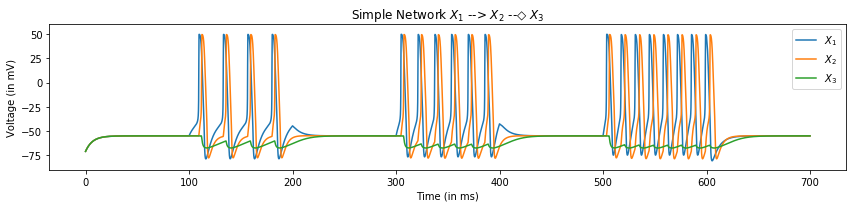

In [10]:
plt.figure(figsize=(12,3))
    
plt.plot(t,state[:,0],label="$X_1$")
plt.plot(t,state[:,1],label="$X_2$")
plt.plot(t,state[:,2],label="$X_3$")
plt.title("Simple Network $X_1$ --> $X_2$ --◇ $X_3$")
plt.ylim([-90,60])
plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")
plt.legend()

plt.tight_layout()
plt.show()

We can see that the current injection triggers the firing of action potentials with increasing frequency with increasing current. Also we see that as soon as the first neuron $X_1$ crosses its fireing threshold, an EPSP is triggered in the next neuron $X_2$ causing a firing with a slight delay from the firing of $X_1$. Finally, as the second neuron depolarizes, we see a corresponding hyperpolarization in the next neuron $X_3$ caused by an IPSP. We can also plot the dynamics of the channels itself by plotting o\_ach and o\_gaba which are the 5th and 4th last elements respectively.

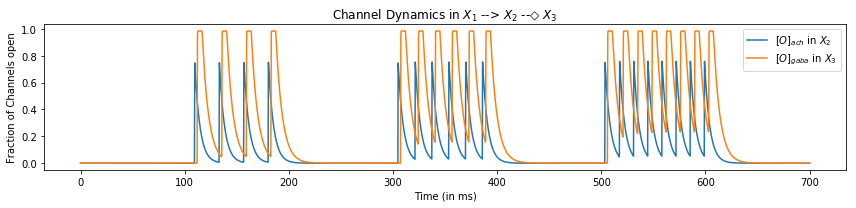

In [11]:
plt.figure(figsize=(12,3))
    
plt.plot(t,state[:,-5],label="$[O]_{ach}$ in $X_2$")
plt.plot(t,state[:,-4],label="$[O]_{gaba}$ in $X_3$")
plt.title("Channel Dynamics in $X_1$ --> $X_2$ --◇ $X_3$")
#plt.ylim([-90,60])
plt.xlabel("Time (in ms)")
plt.ylabel("Fraction of Channels open")
plt.legend()

plt.tight_layout()
plt.show()

Thus we are now capable of making complex networks of neurons with both excitatory and inhibitory connections.